In [1]:
%cd ..


/run/media/nazif/2F946E411BA61D49/thesis


In [2]:
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pd.set_option('display.max_columns', None)

In [64]:
def scale_columns(df, cols):

    # Create a scaler object
    scaler = StandardScaler()

    # Scale the specified columns in the dataframe
    df_scaled = df.copy()
    df_scaled[cols] = scaler.fit_transform(df[cols])

    return df_scaled


def report_performance(model, X, y):
    # Make predictions on the input data
    y_pred = model.predict(X)

    # Calculate performance metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
    }


def get_feature_importances(model):
    """
    Get feature importances of every column from a model.

    Args:
        model: The trained model.

    Returns:
        dict: A dictionary containing the feature importances for each column, with column names as keys.
    """
    feature_importances = {}

    # Check if the model has the attribute "feature_importances_"
    if hasattr(model, "feature_importances_"):
        # Get the feature importances
        importances = model.feature_importances_

        # Get the column names
        if hasattr(model, "get_booster"):
            column_names = model.get_booster().feature_names
        elif hasattr(model, "named_steps"):
            column_names = model.named_steps["preprocessor"].get_feature_names_out(
            )
        else:
            column_names = []

        # Store the feature importances with their respective column names
        for feature_name, importance in zip(column_names, importances):
            feature_importances[feature_name] = importance

        # Sort the feature importances in descending order
        feature_importances = dict(
            sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

    return feature_importances


def compare_importances(model1_importances, model2_importances):
    # Convert dictionaries to DataFrames
    df1 = pd.DataFrame(model1_importances.items(),
                       columns=['Feature', 'Model 1'])
    df2 = pd.DataFrame(model2_importances.items(),
                       columns=['Feature', 'Model 2'])

    # Merge the DataFrames on the 'Feature' column
    merged_df = pd.merge(df1, df2, on='Feature', how='outer')

    # Calculate change and add indicators
    merged_df['Change'] = merged_df.apply(
        lambda row: '+' if row['Model 2'] > row['Model 1'] else ('-' if row['Model 2'] < row['Model 1'] else ''), axis=1)
    merged_df['Importance Change'] = merged_df['Model 2'] - \
        merged_df['Model 1']

    # Sort by Importance Change descending
    merged_df = merged_df.sort_values(by='Importance Change', ascending=False)

    return merged_df.style.apply(
        lambda row: [
            'color:black; background-color: #98ff98'
            if val == '+'
            else (
                'color:black; background-color: #8B0000' if val == '-' else ''
            )
            for val in row
        ],
        axis=1,
    )


def compare_metrics(model1_metrics, model2_metrics):
    # Convert dictionaries to DataFrames
    df1 = pd.DataFrame(model1_metrics.items(), columns=['Metric', 'Model 1'])
    df2 = pd.DataFrame(model2_metrics.items(), columns=['Metric', 'Model 2'])

    # Merge the DataFrames on the 'Metric' column
    merged_df = pd.merge(df1, df2, on='Metric', how='outer')

    # Calculate change and add indicators
    merged_df['Change'] = merged_df.apply(
        lambda row: '+' if row['Model 2'] > row['Model 1'] else ('-' if row['Model 2'] < row['Model 1'] else ''), axis=1)
    merged_df['Change In Value'] = merged_df['Model 2'] - merged_df['Model 1']

    return merged_df.style.apply(
        lambda row: [
            'color:black; background-color: #98ff98'
            if val == '+'
            else (
                'color:black; background-color: #8B0000' if val == '-' else ''
            )
            for val in row
        ],
        axis=1,
    )


def drop_column_and_score(X, y):
    # List of metrics to calculate
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score
    }

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    # Train an initial XGBoost model
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    initial_scores = calculate_metrics(metrics, y_test, model.predict(X_test))
    scores = {'Initial Model': initial_scores}
    # Drop each column one by one and train a new model
    for column in X.columns:
        # Create a new X without the current column
        X_dropped = X.drop(column, axis=1)

        # Split the modified data into train and test sets
        X_train_dropped, X_test_dropped, y_train, y_test = train_test_split(
            X_dropped, y, test_size=0.2, random_state=42, stratify=y)

        # Train a new XGBoost model without the current column
        model_dropped = xgb.XGBClassifier()
        model_dropped.fit(X_train_dropped, y_train)

        # Calculate the scores of the new model
        column_scores = calculate_metrics(
            metrics, y_test, model_dropped.predict(X_test_dropped))
        scores[f'Dropped {column}'] = column_scores

    return pd.DataFrame(scores).T


def calculate_metrics(metrics, y_true, y_pred):
    scores = {}
    for metric_name, metric_func in metrics.items():
        score = metric_func(y_true, y_pred)
        scores[metric_name] = score
    return scores


def stylizer(df):
    def apply_color(row):
        color = []
        for i, cell in enumerate(row):
            if cell == df.iloc[0, i]:
                color.append('background-color: black')
            else:
                if cell > df.iloc[0, i]:
                    color.append('background-color: green')
                else:
                    color.append('background-color: red')
        return color

    return df.style.apply(apply_color, axis=1)

In [54]:
df = pd.read_csv("results/5_features.csv")

# Drop irrelevant columns
cols_to_drop = ["mrna_start", "mrna_end", "mirna_start", "mirna_end",
                "mirna_dot_bracket_5to3", "mirna_sequence", "mirna_accession",
                "mre_region", "enst", "alignment_string"]
df = df.drop(cols_to_drop, axis=1)

# scaling columns
cols_to_scale = ["pred_energy", "ta_log10", "sps_mean"]
df = scale_columns(df, cols_to_scale)

# scale midpoint using minmax
minmax = MinMaxScaler(feature_range=(0, 1))
df["midpoint"] = minmax.fit_transform(df["midpoint"].values.reshape(-1, 1))


# Train test split
X = df.drop("label", axis=1)
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
# Init model
model_initial = xgb.XGBClassifier()
model_initial.fit(X_train, y_train)
report_initial = report_performance(model_initial, X_test, y_test)
init_importances = get_feature_importances(model_initial)

In [57]:
# model 2
# marking all seed types of negative data as 0

rows_to_set_zero = df['label'] == 0
columns_to_set_zero = df.columns[df.columns.str.startswith('seed')]
df.loc[rows_to_set_zero, columns_to_set_zero] = 0

# Train test split
X2 = df.drop("label", axis=1)
y2 = df["label"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2)

# Init model
model_seed_0 = xgb.XGBClassifier()
model_seed_0.fit(X_train2, y_train2)

report_seed_0 = report_performance(model_seed_0, X_test2, y_test2)
seed_0_importances = get_feature_importances(model_seed_0)

In [60]:
compare_metrics(report_initial, report_seed_0)

,Metric,Model 1,Model 2,Change,Change In Value
0,Accuracy,0.985796,0.994674,+,0.008877
1,Precision,0.989972,0.997777,+,0.007805
2,Recall,0.981226,0.991441,+,0.010215
3,F1-Score,0.985580,0.994599,+,0.009019
4,ROC AUC,0.985748,0.994640,+,0.008891


In [65]:
compare_importances(init_importances, seed_0_importances)

,Feature,Model 1,Model 2,Change,Importance Change
16,seed_clash_5,0.004997,0.390724,+,0.385727
11,seed_7mer_m8,0.008858,0.043213,+,0.034355
22,seed_8mer,0.002763,0.032283,+,0.029520
15,seed_clash_4,0.005443,0.019404,+,0.013961
7,pred_seed_basepairs,0.015967,0.027010,+,0.011043
14,seed_7mer_a1,0.005798,0.015934,+,0.010136
23,seed_clash_3,0.000554,0.005772,+,0.005218
18,seed_clash_2,0.004665,0.007782,+,0.003116
24,6mer_seed,0.000000,0.000000,,0.000000
20,supplementary_site,0.004535,0.002616,-,-0.001919


In [116]:
init_col_drop_results = drop_column_and_score(X, y)
seed_0_col_drop_results = drop_column_and_score(X2, y2)

In [124]:
asd = stylizer(init_col_drop_results)
asd.set_caption("Model 1")
asd

,Accuracy,Precision,Recall,F1 Score
Initial Model,0.985796,0.989972,0.981226,0.985580
Dropped pred_energy,0.978694,0.981122,0.975704,0.978405
Dropped pred_num_basepairs,0.985933,0.988886,0.982606,0.985736
Dropped pred_seed_basepairs,0.985933,0.988886,0.982606,0.985736
Dropped ta_log10,0.984021,0.987212,0.980398,0.983793
Dropped sps_mean,0.984704,0.989130,0.979845,0.984466
Dropped anchor_a,0.986343,0.988895,0.983435,0.986157
Dropped 6mer_seed,0.985796,0.989972,0.981226,0.985580
Dropped match_8,0.986479,0.989442,0.983158,0.986290
Dropped 6mer_seed_1_mismatch,0.985660,0.989152,0.981778,0.985451


In [125]:
asd = stylizer(seed_0_col_drop_results)
asd.set_caption("Model 2")
asd

,Accuracy,Precision,Recall,F1 Score
Initial Model,0.994674,0.997777,0.991441,0.994599
Dropped pred_energy,0.991669,0.996376,0.986748,0.991538
Dropped pred_num_basepairs,0.992215,0.995828,0.988404,0.992102
Dropped pred_seed_basepairs,0.994400,0.998330,0.990337,0.994317
Dropped ta_log10,0.992762,0.997491,0.987852,0.992648
Dropped sps_mean,0.994264,0.998330,0.990061,0.994178
Dropped anchor_a,0.994810,0.997501,0.991993,0.994740
Dropped 6mer_seed,0.994674,0.997777,0.991441,0.994599
Dropped match_8,0.993991,0.997774,0.990061,0.993902
Dropped 6mer_seed_1_mismatch,0.994127,0.997775,0.990337,0.994042


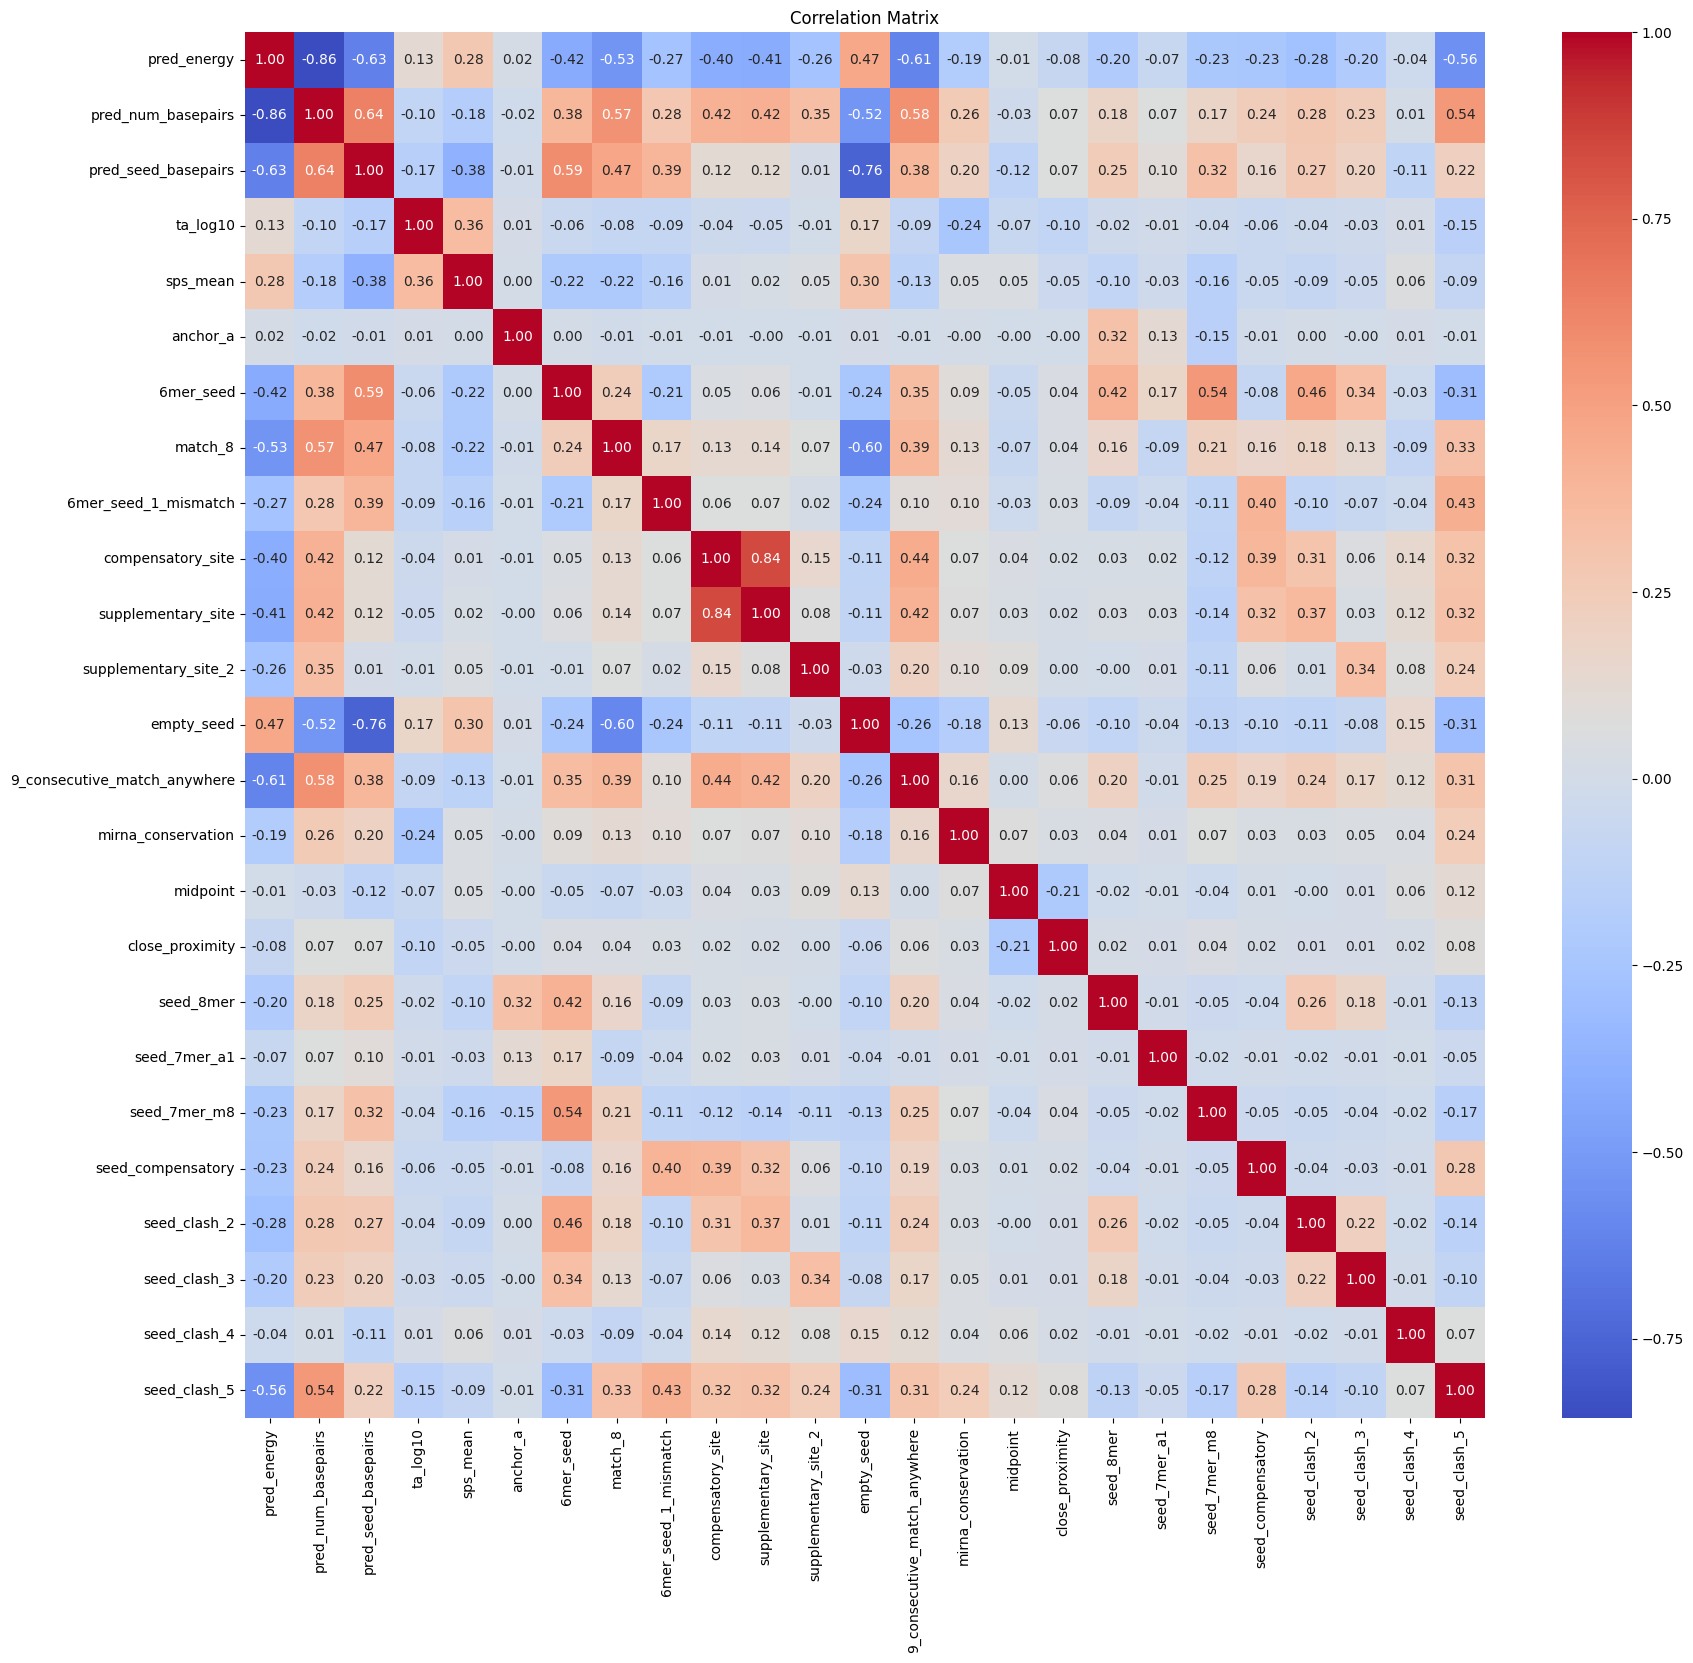

In [128]:
# Assuming your features are stored in a DataFrame called 'data'
correlation_matrix = X2.corr()


import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()